In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from nba_py import player
%matplotlib inline

In [3]:
# Code from https://datascience.stackexchange.com/questions/6084/how-do-i-create-a-complex-radar-chart
# It is a bit altered from the version on stackexchange though, in order to be more flexible and accessable.
def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, n_ordinate_levels=6, should_label_all = False):
        """
        Initializes the ComplexRadar instance which is in charge for plotting a radar plot, or spider plot
        as it is commonly known.
        :param fig: Figure on which the graph will be plotted
        :param variables: Variables for which the data is given, their names will be written on angles of circle
        :param ranges: Either a list of ranges in format (start, end) or a single tuple entry of (start, end) where it is assumed that all variables will have same range
        :param n_ordinate_levels: amount of levels inside circle which will represent divided range, default is 6
        :param should_label_all: Whether grid labels for every variable should be written, default is False, and this is recommended to be true when there are variable ranges
        :return Nothing
        """
        angles = np.arange(0, 360, 360./len(variables))
        
        self.should_scale = False
        self.should_label_all = should_label_all
        
        if len(ranges) == 0:
            for i in range(len(variables)-1):
                ranges.append(ranges[0]) # same range for every category
        else:
            first_d1, first_d2 = ranges[0]
            for d_1, d_2 in ranges[1:]:
                if d_1 > first_d2 or d_2 > first_d2:
                    self.should_scale = True
        
        if self.should_label_all:
            axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True, \
                label = "axes{}".format(i)) for i in range(len(variables))]
        else:
            axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True, label = "axes{}")]
        
        # Place text for variables
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        
        for txt, angle in zip(text, angles):
            if angle > 180:
                txt.set_rotation(angle+90)
            else:
                txt.set_rotation(angle-90)
        
        
        if self.should_label_all:
            for ax in axes[1:]:
                ax.patch.set_visible(False)
                ax.grid("off")
                ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
            
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        
    def plot(self, data, *args, **kw):
        if self.should_scale:
            # Scaling if we have different ranges of data
            sdata = _scale_data(data, self.ranges)
        else:
            sdata = data
        # np.r_ brings first number to the end and copmletes a circle
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        if self.should_scale:
            sdata = _scale_data(data, self.ranges)
        else:
            sdata = data
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

In [4]:
headers = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36'),  # noqa: E501
    'Dnt': ('1'),
    'Accept-Encoding': ('gzip, deflate, sdch'),
    'Accept-Language': ('en'),
    'origin': ('http://stats.nba.com')
    }

In [5]:
def load_nba_dataset_direct_json(json_data):
    shots = json_data['results']
    data_frame = pd.DataFrame(data=shots)
    return data_frame

In [6]:
def plot_radar_for_player(player_seasons, seasons, variables, colors, player_names, bbox_to_anchor, n_ordinate_levels=6):
    
    maximums = []
    for seas in player_seasons:
        maximums.append(max(seas))
    player_max = max(maximums)

    ranges = [(0.01, player_max)]

    # plotting
    fig1 = plt.figure(figsize=(8, 8))
    radar = ComplexRadar(fig1, variables, ranges, n_ordinate_levels=n_ordinate_levels)
    
    for player_season, season_number, color, player_name in zip(player_seasons, seasons, colors, player_names):    
        radar.plot(player_season, label="Points per game based on play type for " + player_name + " in " + season_number, c=color)
        radar.fill(player_season, alpha=0.2, c=color)

    plt.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor, fontsize=11)
    plt.savefig(player_name + " _radar.jpg", bbox_inches='tight')
    plt.show()    

In [14]:
def create_play_type_dataset(target_stat, player_team_id,  past_season, curr_season, is_player=True):

    play_types = ['misc', 'isolation', 'transition', 'PRBallHandler', 'PRRollman', 'postup', 'offrebound', 'spotup', 'handoff', 'cut', 'offscreen']
    column_names = ['Misc', 'Isolation', 'Transition', 'PnR - Ball Handler', 'PnR - Roll Man', 'Post Up', 'Put Back', 'Spot Up', 'Handoff', 'Cut', 'Off Screen']
    player_current_list, player_past_list = [], []
    for i, play_type in enumerate(play_types):
        if is_player:
            player_or_team = "player"
        else:
            player_or_team = "team"
        url_type_curr = "https://stats-prod.nba.com/wp-json/statscms/v1/synergy/" + player_or_team + "/?category=" + play_type + "&limit=500&names=offensive&q=2516338&season=" + curr_season + "&seasonType=Reg"
        url_type_past = "https://stats-prod.nba.com/wp-json/statscms/v1/synergy/" + player_or_team + "/?category=" + play_type + "&limit=500&names=offensive&q=2516338&season=" + past_season + "&seasonType=Reg"
        past_df = load_nba_dataset_direct_json(requests.get(url_type_past, headers=headers).json())
        curr_df = load_nba_dataset_direct_json(requests.get(url_type_curr, headers=headers).json())
        if is_player:
            identifier = "PlayerIDSID"
        else:
            identifier = "TeamIDSID"
        if past_df[identifier].isin([player_team_id]).any():
            past_df = past_df.loc[past_df[identifier] == player_team_id]
            stat_value = past_df[target_stat].iloc[0]
            if stat_value < 0.1:
                player_past_list.append(0.1)
            else:
                player_past_list.append(stat_value)
        else:
            player_past_list.append(0.1)
        if curr_df[identifier].isin([player_team_id]).any():
            curr_df = curr_df.loc[curr_df[identifier] == player_team_id]
            stat_value = curr_df[target_stat].iloc[0]
            if stat_value < 0.1:
                player_current_list.append(0.1)
            else:
                player_current_list.append(stat_value)
        else:
            player_current_list.append(0.1)
        
    return player_current_list, player_past_list, column_names

In [8]:
player_id = player.get_player("Stephen", "Curry").iloc[0]

In [15]:
curr, past, columns = create_play_type_dataset('PPG', player_id, "2016", "2017")

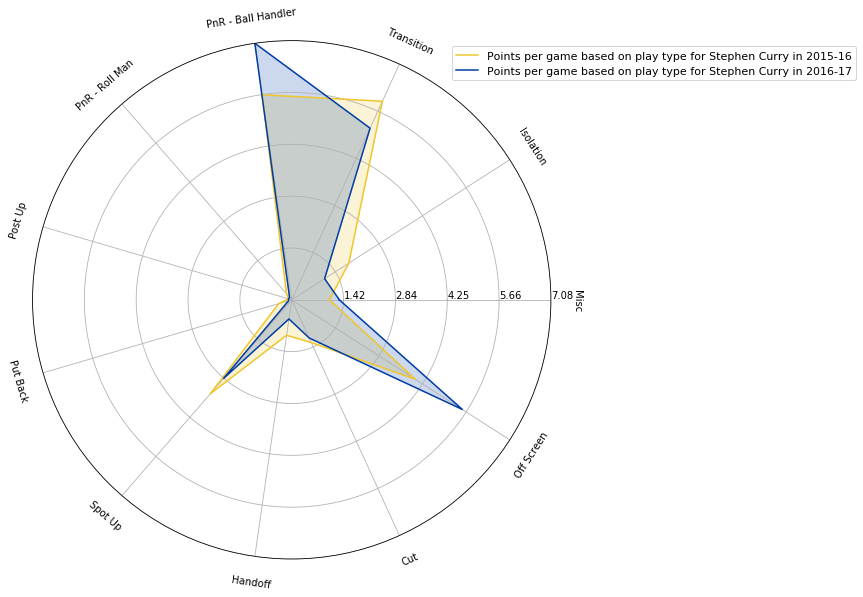

In [16]:
player_seasons = [past, curr]
seasons = ["2015-16", "2016-17"]
colors = ["#EFC72D", "#003DA5"]
player_names = 2 * ["Stephen Curry"]
plot_radar_for_player(player_seasons, seasons, columns, colors, player_names, (1.60, 1), n_ordinate_levels=6)